# Time Series Analysis for Temperature Forecast
---
***Gods must be crazy. Finally I have some work that is not owned by my University as part of my course work and I can share publically.***  
*This can be a good article for the ones who are trying their hands on on Time Series Analysis.*  

Our data set contains monthly temperature values for multiple cities from the year 1783. But, for our learning, we will only focus on the one city which will have consistent and non redundant data. We will learn ARIMA and how to find optimal order for the ARIMA model.

For the theory part, I am putting an overview below but I will also link some amazing resources during and at the end of this article.

The core idea of a time series analysis is that the current value depends on past values. How many of the past values? Let us call this "lag". Here, we are forecasting the average temperature for the current month. Say we consider a lag of 10. This means, we will consider the temperatures of past 10 months to forecast the temperature for the current month. How much lag to consider becomes the challenge. We will try to understand how to figure out a solution for this.

## ARIMA
ARIMA can be split into AR(Auto Regressor) I(Integrated) MA(Moving Averages).
Auto Regressor fits the model like a regressor. Like y = mx + c where we can have multiple x. Multiple x does not mean we have multiple features. Number of Xs mean the lag value. Better explanation of this is possible on a video and I would recommend [this](https://www.youtube.com/watch?v=2XGSIlgUBDI) by our teaching legend, Krish Naik.

In the similar manner, MA is based on the error terms of the previous value and we map a linear regression with the coefficients for these errors. This too is explained way better in Krish Naik's video.

[Dataset](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data) can be found here and I am skipping it in my repository.

Let us import all the necessary modules. All of these exists in the requirements.txt which is added in the github repo.

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000 # set to read a csv file this long

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByCity.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


We see multiple columns here but we are only concerned with `dt` while cleaning our data, `City` while filtering our data and eventually, we will only work on `AverageTemperature`. For this reason, we will not focus on filtering or cleaning the other data.

In [3]:
# convert dt to datetime
df['dt'] = pd.to_datetime(df['dt'])
# check nan values
df.isnull().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

364k null values. 
- These values can be replaced with the previous month's temperature for that city.
- But our data might not necessarily be in the format where the previous row would have the temperature for the previous month for the same city. With this anomaly, say a city X in the southern part can appear before city Y that is in the northern part. To fill the null value in Y, we cannot really use temperature from some city in the south. This will result in errorneous data.
- Let us sort the data by city and by date. With this, we will have all the dates sorted for each city.
Let us go ahead and fill out the missing values

In [4]:
df = df.sort_values(by=['City', 'dt'])
# fill the missing values with ffill. ffill will propagate last valid observation forward to next valid
df['AverageTemperature'] = df['AverageTemperature'].fillna(method='ffill')
# we skipped the AverageTemperatureUncertainty column because it is not important for our analysis

# get the city that has the most amount of data
df['City'].value_counts().sort_values(ascending=True).head(10)

City
Port Moresby    1581
Trujillo        1584
Chimbote        1584
Chiclayo        1584
Loja            1591
Piura           1591
Tumbes          1591
Cuenca          1591
Pucallpa        1591
Guayaquil       1591
Name: count, dtype: int64

Let us try out "Port Moresby" city temperatures

In [5]:
df = df[df['City'] == 'Port Moresby']
# get number of unique values for dt
print("Number of unique values for dt: ", len(df['dt'].unique()), df.shape)

Number of unique values for dt:  1581 (1581, 7)


This precisely means that all the values are distint for `dt`.  
*This dataset has monthly values instead of daily. We will come to this later.*

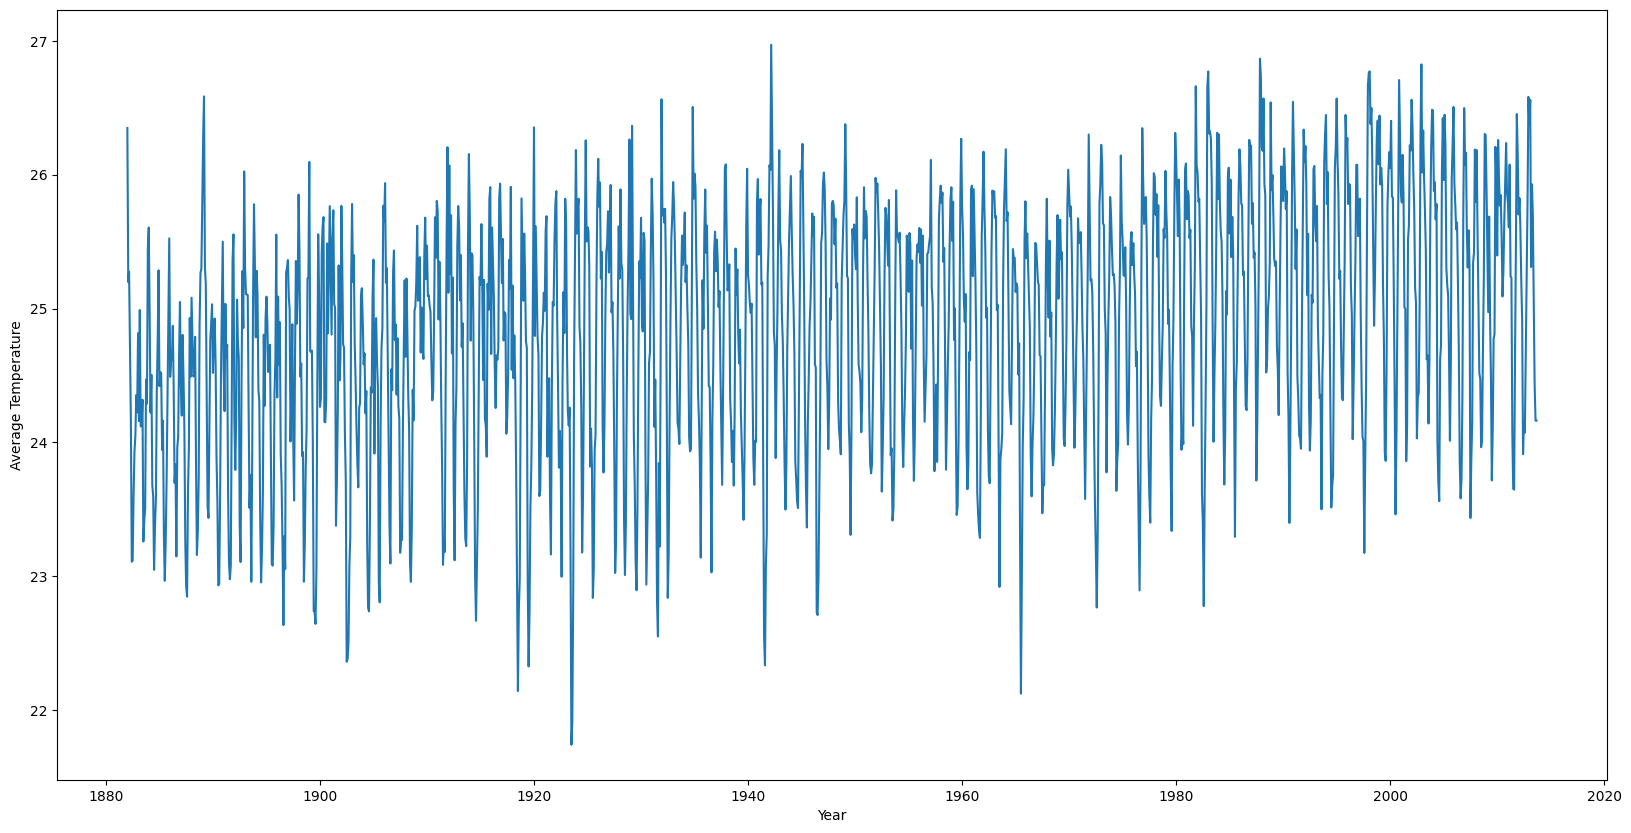

In [6]:
# plot the graph for dt and AverageTemperature
plt.figure(figsize=(20,10))
plt.plot(df['dt'], df['AverageTemperature'])
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.show()

Drop all the other data and reset the index as we dont truely need `dt` anymore and `AverageTemperature` alone can be used from here.

In [7]:
# set index to dt and keep only the columns we need
df = df[['AverageTemperature']]
# reset index to range from 0 to len
df = df.reset_index(drop=True)
df.head()

,AverageTemperature
0,26.349
1,25.197
2,25.275
3,24.733
4,24.154


# Implement ARIMA
---
But, ARIMA is based on the assumption that the data is stationary. This means that data should have a constant mean and standard deviation.  
Let us implement the Dickey Fuller test where we have the below hypothesis.
1. Null Hypothesis: Our data is seasonal and not stationary.
2. Alternate Hypothesis: Our data is stationary.

Dickey Fuller test gives us the pvalue for this and with a pvalue lower then 0.05, we can reject the null hypothesis.

In [8]:
adFullerResult = adfuller(df['AverageTemperature'])
pValue = adFullerResult[1]
if pValue < 0.05:
    print('The data is stationary')
else:
    print('The data is not stationary')

The data is stationary


ARIMA can now be implemented as our data is as per the assumption of the ARIMA.  
This is the perfect time to split the data into train and test. Let us do 90% and 10% as 10% is easier to plot on the graph

In [9]:
from sklearn.model_selection import train_test_split
trainData, testData = train_test_split(df, test_size=0.1, shuffle=False) # set random state to 1 as we cannot randomly pick elements

Since the data is stationary, we dont need the differencing and hence the d is 0 among p, d and f.  
- p: Lag order  
- d: Differencing order  
- f: order of moving averages  

We will plot the ACF and PACF graph.   
- For the order of the AR model, we look at the PACF plot.
- For the order of the MA model, we look at the ACF plot.
In both the cases, we look at the number of candles outside of the confidence boundary and we skip the 0 as the correlation with itself will always result in 1.   

I developed my understanding about this from [Interpreting ACF and PACF Plots for Time Series Forecasting](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c).

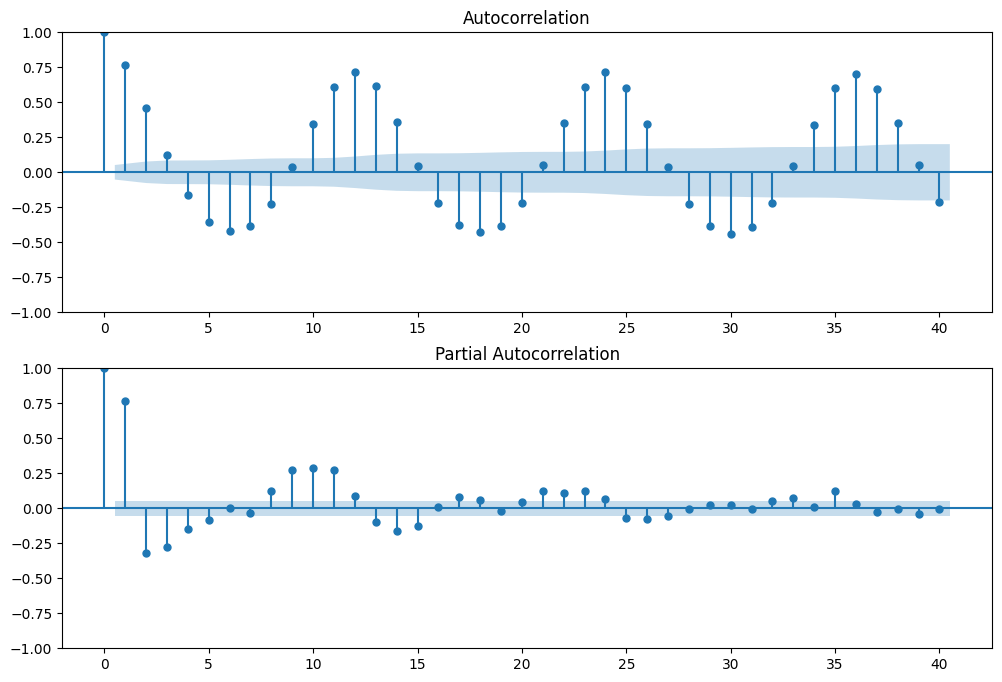

In [10]:
# plot the acf and pacf of the time series
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trainData['AverageTemperature'], ax=ax1, lags = 40) 
ax2 = fig.add_subplot(212)
fig = plot_pacf(trainData['AverageTemperature'], ax=ax2, lags = 40)

## Identify the order of AR and MA 
---
*As mentioned earlier, this temperature follows a pattern that repeats after a cycle of 12 values. This signifies that the data is seasonal. I posted this on [stackexchange](https://stats.stackexchange.com/questions/623613/arima-flattens-out-on-one-order-and-works-perfect-on-another) as the results came as below and that is not what we expect.*
- Here, we see that the p value is 8 and q value of 5

**We will fit this only on the training data.**

<Axes: >

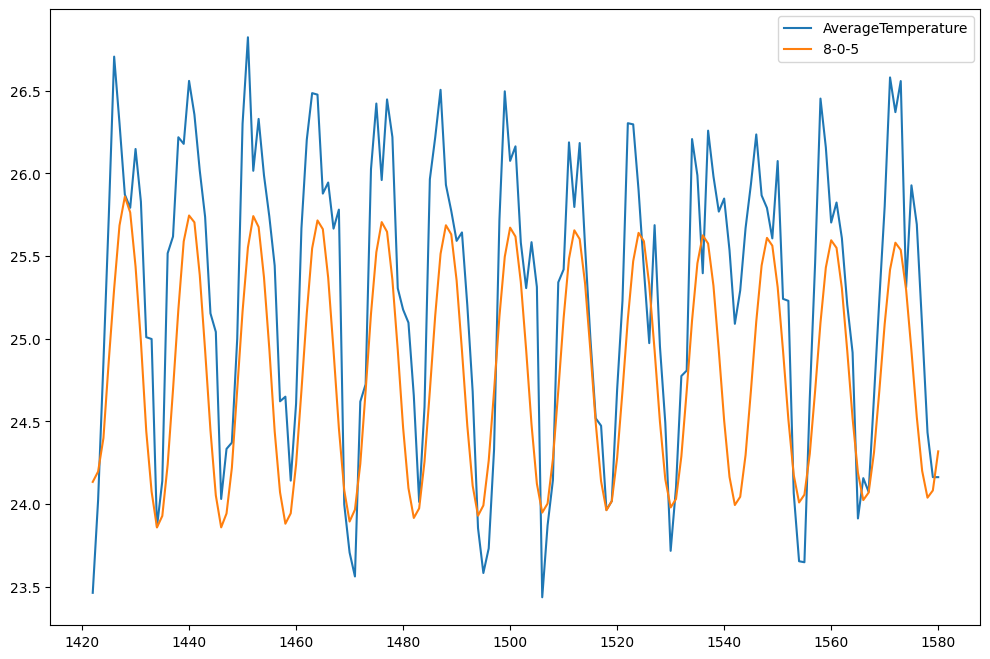

In [11]:
# Implement ARIMA with p = 8, d = 0 and q = 5
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

model = ARIMA(trainData['AverageTemperature'], order=(8,0,5))
model_fit = model.fit()

# predict the result for the test data
testData['8-0-5'] = model_fit.predict(start=1422, end=1581, dynamic=True)

# plot the result
testData.plot(figsize = (12, 8))

Sadly, the result is good but let us see if we can do better.
Let us go with grid search for other parameters. I got a lot of time so let me just try 0 to 8 values for both p and q.

In [12]:
import itertools
p = q = range(0, 8)
pq = list(itertools.product(p, q))
minAIC, minParams = float('inf'), None
print("Trying total of {} combinations".format(len(pq)))
for ind, param in enumerate(pq):
    param = (param[0], 0, param[1])
    try:
        mod = ARIMA(trainData['AverageTemperature'], order=param)
        results = mod.fit()
        aic = results.aic
        if aic < minAIC:
            minAIC, minParams = aic, param
        if (ind + 1) % 10 == 0:
            print("Finished {} combinations".format(ind + 1))
    except Exception as e:
        print("Caught exception for {}: {}".format(param, e))
        continue
print("Minimum AIC: {} for params {}".format(minAIC, minParams))

Trying total of 64 combinations
Finished 10 combinations
Finished 20 combinations
Finished 30 combinations
Finished 40 combinations
Finished 50 combinations
Finished 60 combinations
Minimum AIC: 1800.6974236826677 for params (4, 0, 5)


We find that the optimal parameters are (4, 0, 5) which give the lowest AIC score. Fit on the training data and see how this performs on the forcasting aspect.

<Axes: >

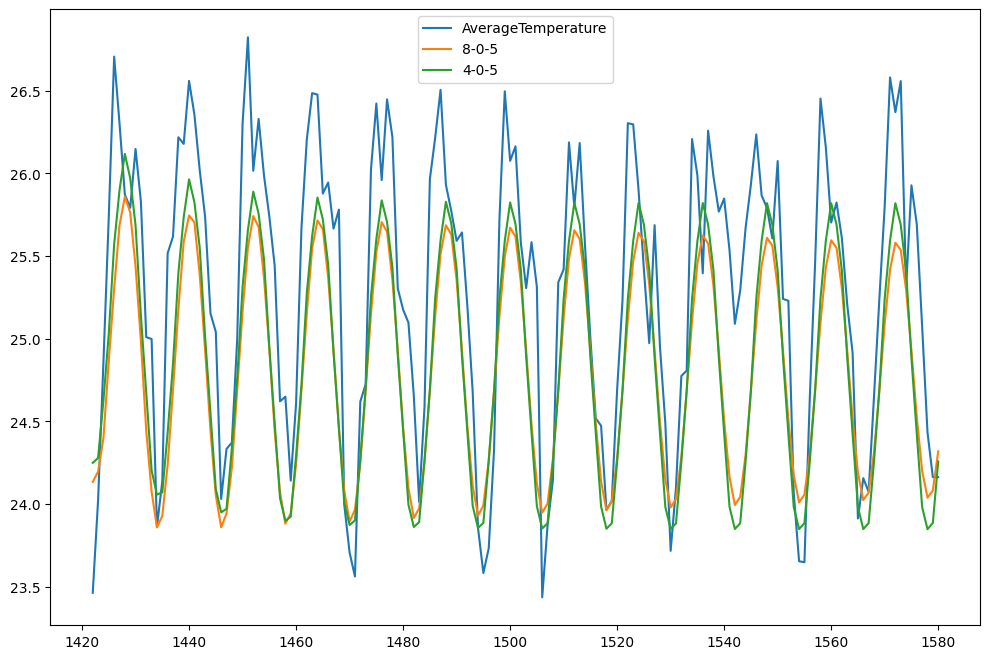

In [13]:
model = ARIMA(trainData['AverageTemperature'], order=minParams)
model_fit = model.fit()
modelName = "-".join(map(str, list(minParams)))
testData[modelName] = model_fit.predict(start=1422, end=1581)
testData.plot(figsize=(12,8))

But, [this](https://stats.stackexchange.com/questions/285093/why-does-default-auto-arima-stop-at-5-2-5) post shows why higher orders of ARIMA would not perform well. Also in [my original post](https://stats.stackexchange.com/questions/623613/arima-flattens-out-on-one-order-and-works-perfect-on-another), Stephan mentions why one should implement an auto-ARIMA instead of what we did as our forecast flattens out. Implementing the grid search too was something similar.   

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2652.236, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13171.638, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11262.649, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2648.156, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2643.150, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2204.273, Time=0.30 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=2146.640, Time=0.50 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=2101.144, Time=0.92 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=2091.491, Time=1.14

<Axes: >

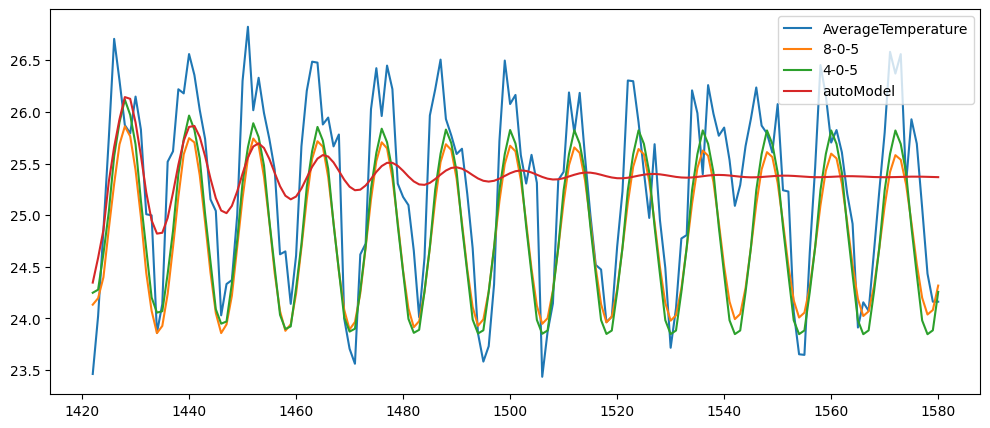

In [16]:
from pmdarima.arima import auto_arima
autoModel = auto_arima(trainData['AverageTemperature'], start_p=1, start_q=1,
                           max_p=8, max_q=8, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
# fit the model on the train set
autoModel.fit(trainData['AverageTemperature'])
testData['autoModel'] = autoModel.predict(n_periods=testData.shape[0])
testData.plot(figsize=(12,5))

Woah Woah. Stephan said that this data would flatten out mathematically and it happens so. But, our actual forcast should not flatten out. Forecasting constant values will not add any value.   
Fortunately, I could reach out to Stephan and he suggest me other models that can be implemented and have better performance. A lot more to implment and learn from. 

Concluding this one here.
- ARIMA is a benchmark model but it is practically tough to identify the optimal order. 
- Our forcast will flatten out and this is not what we want.
- ACF and PACF plots are insightful but not very accurate to judge the optimal order of the AR and MA models.
- Dickey Fuller test specifies whether our data is stationary only in one aspect. We should implement robust mdoels that can handle these assumptions.

In [3]:
# save the current ipynb as a markdown file and include the code cells too. This will become the readme file for the repository
!jupyter nbconvert --to markdown "Temperature Forecast ARIMA.ipynb" --output README.md --TemplateExporter.exclude_input=False

[NbConvertApp] Converting notebook Temperature Forecast ARIMA.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 16744 bytes to README.md
